<a href="https://colab.research.google.com/github/srishtikara/Toxic-Comment-Classification/blob/master/Toxic_Comment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The purpose of this project is to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate from comments. I will be using a dataset of comments from Wikipedia’s talk page edits. Online platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments. This project can build a model to help platforms deal with the problem of toxic comments on the internet. 

#Import libraries and load data
Import the standard keras library

In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Next, I loaded the train and test files from my google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
train = pd.read_csv('/content/gdrive/My Drive/train.csv')
test = pd.read_csv('/content/gdrive/My Drive/test.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Here you can see the first 5 rows of the data and see the preview of the train and test dataset.



In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Preprocessing Steps
Now, check for nulls. If missing, fill the null values with something else before proceeding.



In [ ]:
train.isnull().any(),test.isnull().any()


(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

It looks like there are no null values. Great news!

# Tokenization, Indexing, Index representation using Keras

The goal is to feed the comments into the LSTM as part of the neural network. Long short-term memory (LSTM) is an artificial recurrent neural network architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points, but also entire sequences of data.

As seen in the preview of the data, the dependent variables are in the training set. Hence, I first have to split them into X and Y sets.

Tokenization is the process of turning a meaningful piece of data, such as an account number, into a random string of characters called a token that has no meaningful value if breached. First I break down the sentence into unique words. Next, apply indexing which means to put the words in a structure and give them an index. Then, one can represent the sequence of words in the comments in the form of an index.

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [ ]:
list_tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

As you can see Keras has turned our words into index representation for us.

Some comments are bound to be very long, whereas some may just be one word. In this case, we can use "padding" in order to make the shorter sentences longer by filling in zeros. We might also have to trim the longer sentences to the same length as the shorter ones. In this case, we have set a max length.

It is very important to make sure you do not put a max length to be too short we might lose some useful feature that could reduce accuracy.If you put the max length too long, LSTM cell will have to be larger to store more.

I decided to see the distribution of the number of words in sentences to decide the max length.

As seen in the histogram, most of the sentence length is about 30+. To be safe, I set the "maxlen" to 100.

In [ ]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]


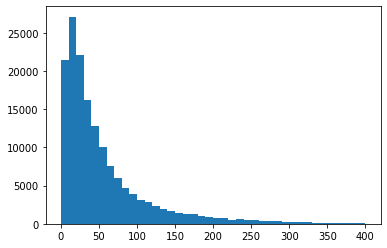

In [ ]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()


In [ ]:
maxlen = 100
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

# Embedding

I want Keras to infer the number automatically. An empty space after comma will do just that.



In [ ]:
inp = Input(shape=(maxlen, )) #maxlen=100 as defined earlier



"Word Embeddings are the texts converted into numbers and there may be different numerical representations of the same text. Many Machine Learning algorithms and almost all Deep Learning Architectures are incapable of processing strings or plain text in their raw form. They require numbers as inputs to perform any sort of job, be it classification, regression etc. in broad terms. And with the huge amount of data that is present in the text format, it is imperative to extract knowledge out of it and build applications. A Word Embedding format generally tries to map a word using a dictionary to a vector. A vector representation of a word may be a one-hot encoded vector where 1 stands for the position where the word exists and 0 everywhere else. The vector representation of “numbers” in this format according to the above dictionary is [0,0,0,0,0,1] and of converted is[0,0,0,1,0,0]." (www.analyticsvidhya.com)

We project words to a defined vector space depending on the distance of all the surrounding words in a sentence. 

Embedding allows us to reduce model size and the dimensions. The output of the Embedding layer is a list of the coordinates of the words in this vector space.

Note: We need to define the size of the "vector space"  and the number of unique words(max_features) we are using.  In this case, the embedding size is a parameter that you can tune and experiment to get better accuracy. 

In [ ]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

# LSTM

Next, I feed this Tensor into the LSTM layer and set the LSTM to produce an output that has a dimension of 60. We want it to return the entire unrolled sequence of results. 


In [ ]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)


# Max Pooling

Now, we have to reshape the output from the 3D tensor into a 2D tensor.  I used a Global Max Pooling layer. Here, we go through each patch of data and take the maximum values of each patch. These collection of maximum values will be a new set of down-sized data we can use.

In [ ]:
x = GlobalMaxPool1D()(x)


# Dropout, Dense, Dropout, Dense

Now, moving on to the dropout layer. This "disables” some nodes so that the nodes in the next layer is forced to handle the representation of the missing data and the whole network could result in better generalization.

Set the dropout layer to drop out 10%(0.1) of the nodes.



In [ ]:
x = Dropout(0.1)(x)


After a drop out layer, I connected the output of drop out layer to a densely connected layer and the output passes through a RELU function. 

This is what it does:

Activation( (Input X Weights) + Bias)

I have defined the Dense layer to produce a output dimension of 50.


In [ ]:
x = Dense(50, activation="relu")(x)


Now, I feed the output into a Dropout layer again.



In [ ]:
x = Dropout(0.1)(x)


Finally, I feed the output into a Sigmoid layer. 

The sigmoid function will squash the output between the bounds of 0 and 1 and we are trying to get a binary classification(1,0) for each of the 6 labels. 



In [ ]:
x = Dense(6, activation="sigmoid")(x)


Now, I define the inputs, outputs and configure the learning process. 

I have set the model to optimize loss function using Adam optimizer. I have defined the loss function to be "binary_crossentropy" since we are tackling a binary classification.


In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Now it is finally time to test the model! 

I will feed in a list of 32 padded, indexed sentence for each batch and split 10% of the data as a validation set. 

For each batch this validation set will be used to assess whether the model has overfitted.

The model will run for 2 epochs. 

Note: the parameters can be changed.


In [ ]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 520s 4ms/step - loss: 0.0691 - accuracy: 0.9779 - val_loss: 0.0498 - val_accuracy: 0.9818
Epoch 2/2
143613/143613 [==============================] - 519s 4ms/step - loss: 0.0458 - accuracy: 0.9829 - val_loss: 0.0511 - val_accuracy: 0.9822


# Conclusion

The accuracy is very good. Keras cuts down a lot of time and one does not have to spend a ton of time defining the right dimensions for matrices. Keras is an open-source neural-network library written in Python. It is capable of running on top of TensorFlow, Microsoft Cognitive Toolkit, R, Theano, or PlaidML. Designed to enable fast experimentation with deep neural networks, it focuses on being user-friendly, modular, and extensible. Now, instead of spending time on defining the right dimentions for matrices, I can spend time on experimenting with different variations of model.